# Clustering Model Selection

We run a handful of clustering algorithms and hyperparameter combinations and try to make sense of the quality of results.

In [28]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

In [61]:
data = pd.read_csv('../data/features/incidents/use_of_force.csv')
# Read in data

## Create training data
### ... by filtering rows

In [62]:
# the row filter subsets the index too. we reset it here to make it easier to concatenate the training labels later on
training_data = data.loc[data['YEAR'] == 2016].reset_index(drop=True)

### ... by filtering columns

In [63]:
# Drop dates and demographics and geographies
training_data = training_data.drop(['CPD_MEMBER','DATE','BEAT','WARD','DATETIME','YEAR','MONTHYEAR','SUBJECT_GENDER','SUBJECT_RACE','TRR_REPORT_ID','Year of SUBJECT_BIRTH','COMMUNITY_AREA','DISTRICT', 'RD_NO'], axis=1)

# Drop columns with nans because there isn't time to fix it.
nan_cols = training_data.columns[training_data.isna().sum() > 0]
training_data = training_data.drop(nan_cols, axis=1)

## Preprocess / transform data

In [64]:
from sklearn.preprocessing import StandardScaler
# Normalize columns
# This puts all features at same importance. We may want type or shootings to be more important somehow.
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(training_data), columns=training_data.columns)

In [65]:
from sklearn.decomposition import PCA
# Do PCA
pca = PCA()
pca.fit(data_scaled)
data_pc = pd.DataFrame(pca.transform(data_scaled))

## Do clustering

In [119]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from util_clustering import grid_search_clustering

params_km = {'n_clusters':[2,3,4,5,7,9]}
km_result = grid_search_clustering(KMeans(), \
    ParameterGrid(params_km), data_pc, 'inertia_')

params_hagg = {'n_clusters':[2,3,4,5,7,9], 'affinity':['euclidean','cosine'], 'linkage':['complete','average','single']}
hagg_result = grid_search_clustering(AgglomerativeClustering(), \
    ParameterGrid(params_hagg), data_pc)

params_dbscan = {'eps':[.01,.1,.2,.5,.9], 'min_samples':[2, 5, 10, 100], 'metric':['euclidean','cosine']}
dbscan_result = grid_search_clustering(DBSCAN(), \
    ParameterGrid(params_dbscan), data_pc)

params_gauss = {'n_components':[2,3,4,5,7,9], 'n_init':[1,10]}
gauss_result = grid_search_clustering(GaussianMixture(), \
    ParameterGrid(params_gauss), data_pc, 'lower_bound_')

params_spectral = [{'affinity': ['rbf'], 'n_clusters':[2,3,4,5,7,9]}, \
                   {'affinity': ['nearest_neighbors'], 'n_clusters':[2,3,4,5,7,9], \
                       'n_neighbors':[2, 5, 10, 100]}]
# spectral_result = grid_search_clustering(SpectralClustering(), \
    # ParameterGrid(params_spectral), data_pc)

param_results = pd.concat([km_result, hagg_result, dbscan_result, gauss_result]) #, \
     #spectral_result])

Training KMeans with: {'n_clusters': 2}
Training Time Elapsed: 0:00:00.069333
Training KMeans with: {'n_clusters': 3}
Training Time Elapsed: 0:00:00.088357
Training KMeans with: {'n_clusters': 4}
Training Time Elapsed: 0:00:00.089567
Training KMeans with: {'n_clusters': 5}
Training Time Elapsed: 0:00:00.105988
Training KMeans with: {'n_clusters': 7}
Training Time Elapsed: 0:00:00.133434
Training KMeans with: {'n_clusters': 9}
Training Time Elapsed: 0:00:00.142848
Grid search completed.
Training AgglomerativeClustering with: {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 2}
Training Time Elapsed: 0:00:01.207981
Training AgglomerativeClustering with: {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 3}
Training Time Elapsed: 0:00:01.072261
Training AgglomerativeClustering with: {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 4}
Training Time Elapsed: 0:00:01.058796
Training AgglomerativeClustering with: {'affinity': 'euclidean', 'linkage': 'com

### Apply cluster labels to training data


In [120]:
def assign_clusterings(param_results, training_data):
    """
        Take the best model according to different metrics and extract the labels it produced
        Apply label vectors to original data frame
    """
    best_labels_km = param_results.loc[param_results['Model']=='KMeans'] \
        .sort_values(by='Score', ascending=True) \
        .head(1)['Labels'].to_numpy()[0]
    best_labels_gauss = param_results.loc[param_results['Model']=='GaussianMixture'] \
        .sort_values(by='Score', ascending=False) \
        .head(1)['Labels'].to_numpy()[0]
    best_labels_dbscore = param_results.sort_values(by='Davies-Bouldin', ascending=True) \
        .head(1)['Labels'].to_numpy()[0]
    best_labels_vrscore = param_results.sort_values(by='Halinski-Harabasz', ascending=True) \
        .head(1)['Labels'].to_numpy()[0]
    best_labels_silscore = param_results.sort_values(by='Silhouette', ascending=False) \
        .head(1)['Labels'].to_numpy()[0]

    label_cols = ['KMeans', 'Gauss', 'Davies', 'VarRatio', 'Silo']
    clustered = pd.concat([training_data, \
                        pd.Series(best_labels_km, name='KMeans'), \
                        pd.Series(best_labels_gauss, name='Gauss'), \
                        pd.Series(best_labels_dbscore, name='Davies-Bouldin'), \
                        pd.Series(best_labels_vrscore, name='Halinski-Harabasz'), \
                        pd.Series(best_labels_silscore, name='Silhouette'), \
                        ], axis=1)
    return clustered

## Try to make sense of results
### ... by plotting colored projections of data

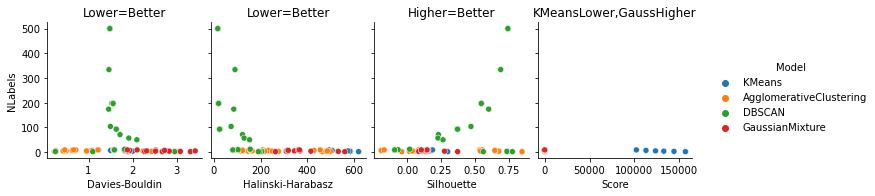

In [121]:
g = sns.pairplot(data=param_results, y_vars="NLabels",x_vars=["Davies-Bouldin","Halinski-Harabasz","Silhouette","Score"],hue="Model")
metric_titles = ['Lower=Better','Lower=Better','Higher=Better','KMeansLower,GaussHigher']
for ax, title in zip(g.axes.flat, metric_titles):
    ax.set(title=title)

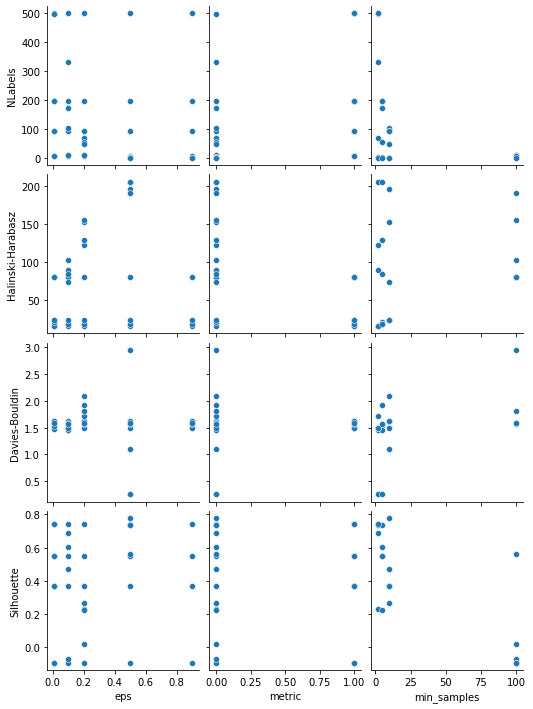

In [134]:
dbscan_results = param_results.loc[param_results['Model'] == 'DBSCAN',:] #\
dbscan_results = pd.concat([dbscan_results, pd.json_normalize(dbscan_results['Params'])],axis=1)
dbscan_results['metric'] = dbscan_results['metric'].replace('cosine',0).replace('euclidean',1)
sns.pairplot(dbscan_results, \
    y_vars=['NLabels','Halinski-Harabasz', 'Davies-Bouldin','Silhouette'],\
        x_vars =['eps','metric','min_samples'])


<AxesSubplot:>

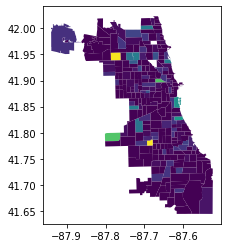

In [135]:
import scipy
# Plot clusters geographically
# beat_geos = gpd.read_file('../data/geographies/Boundaries - Police Beats (current).geojson')
# beat_geos = beat_geos.assign(BEAT = pd.to_numeric(beat_geos['beat_num'], errors='coerce'))
# data_2016 = data.loc[data['YEAR'] == 2016].reset_index(drop=True)
beat_clusters = clustered.assign(BEAT=data_2016.BEAT)
beat_clusters_agg = beat_clusters.groupby(by='BEAT') \
     .agg({'Halinski-Harabasz': lambda g: scipy.stats.mode(g)[0]}) \
     .assign(HH_SCORE = lambda x: x['Halinski-Harabasz'])
beat_clusters_agg_geo = beat_geos.merge(beat_clusters_agg, how='inner', on=['BEAT'])
beat_clusters_agg_geo.plot('HH_SCORE')


### ... by learning supervised models on clustering to get feature importance

<AxesSubplot:>

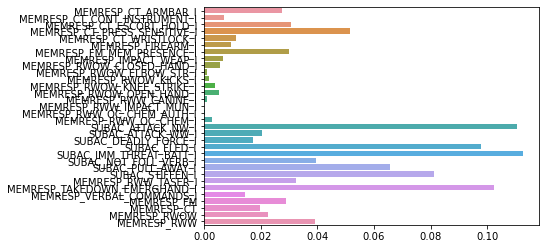

In [136]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(training_data, clustered['Halinski-Harabasz'])
sns.barplot(y=training_data.columns, x=tree.feature_importances_)

### ... by searching all cluster sizes and watching feature importance

In [93]:
max_clusters = min(training_data.shape[1], training_data.shape[0])
params_km_sweep = {'n_clusters':np.arange(1,max_clusters)}
km_sweep_result = grid_search_clustering(KMeans(), ParameterGrid(params_km_sweep), data_scaled, 'inertia_')

Training KMeans with: {'n_clusters': 1}
Training Time Elapsed: 0:00:00.104786
Training KMeans with: {'n_clusters': 2}
Training Time Elapsed: 0:00:00.068549
Training KMeans with: {'n_clusters': 3}
Training Time Elapsed: 0:00:00.070522
Training KMeans with: {'n_clusters': 4}
Training Time Elapsed: 0:00:00.103962
Training KMeans with: {'n_clusters': 5}
Training Time Elapsed: 0:00:00.126449
Training KMeans with: {'n_clusters': 6}
Training Time Elapsed: 0:00:00.139646
Training KMeans with: {'n_clusters': 7}
Training Time Elapsed: 0:00:00.134577
Training KMeans with: {'n_clusters': 8}
Training Time Elapsed: 0:00:00.144322
Training KMeans with: {'n_clusters': 9}
Training Time Elapsed: 0:00:00.166166
Training KMeans with: {'n_clusters': 10}
Training Time Elapsed: 0:00:00.160675
Training KMeans with: {'n_clusters': 11}
Training Time Elapsed: 0:00:00.164898
Training KMeans with: {'n_clusters': 12}
Training Time Elapsed: 0:00:00.170080
Training KMeans with: {'n_clusters': 13}
Training Time Elapse

In [137]:
from sklearn.metrics import accuracy_score

sweep_labels = {}
for row in km_sweep_result.itertuples():
    sweep_labels[row.NLabels] = row.Labels

sweep_importances = {}
sweep_accuracy = {}
colors = sns.color_palette(palette='flare',n_colors=max_clusters)
for nlabels in sweep_labels.keys():
    tree.fit(training_data, sweep_labels[nlabels])
    sweep_importances[nlabels] = pd.Series(tree.feature_importances_, name=str(nlabels))
    sweep_accuracy[nlabels] = accuracy_score(sweep_labels[nlabels], tree.predict(training_data))
    # g = sns.barplot(y=training_data.columns, x=tree.feature_importances_, color=colors[nlabels])




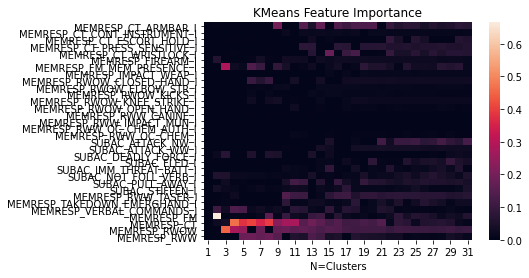

In [138]:
sweep_importance_df = pd.DataFrame(sweep_importances)
sweep_importance_df_melted = sweep_importance_df \
    .assign(FEATURE = lambda x: training_data.columns[x.index]) \
    .melt(id_vars='FEATURE', var_name='nclusters', value_name="importance")
sns.heatmap(sweep_importance_df, yticklabels=training_data.columns).set(xlabel='N=Clusters', title='KMeans Feature Importance');

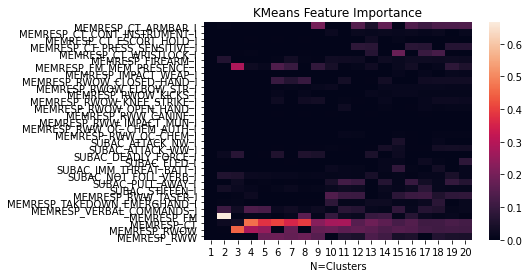

In [139]:
sns.heatmap(sweep_importance_df.loc[:,0:20], yticklabels=training_data.columns).set(xlabel='N=Clusters', title='KMeans Feature Importance');